Pixeltests School Data Science

*Unit 2, Sprint 2, Module 2*

---

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/pixeltests/datasets/main/' #You might not need this, use the data from Kaggle directly!
    !pip install category_encoders
    !pip install pandas-profiling

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Module Project: Random Forests

This week, the module projects will focus on creating and improving a model for the Tanazania Water Pump datset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

The tasks for this project are as follows:

- **Task 1:** Enter the [Kaggle](https://www.kaggle.com/t/6169ee7701164d24943c98eda2de9b5e) competition using exactly this link!
- **Task 2:** Use `wrangle` function to import training and test data.
- **Task 3:** Split training data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build and train `model_dt`.
- **Task 7:** Calculate the training and validation accuracy score for your model.
- **Task 8:** Adjust model's `max_depth` to reduce overfitting.
- **Task 9 `stretch goal`:** Create a horizontal bar chart showing the 10 most important features for your model.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `sklearn`

# I. Wrangle Data

In [3]:
import pandas as pd
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path,
                                  na_values=[0, -2.000000e-08], compression='zip'),
                      pd.read_csv(tv_path, compression='zip'), left_index=True, right_index=True).set_index('id')
    else:
        df = pd.read_csv(fm_path,
                         na_values=[0, -2.000000e-08],
                         index_col='id', compression='zip')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(15).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)

    return df

**Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account. Choose a username that's based on your real name. Like GitHub, Kaggle is part of your public profile as a data scientist.

**Task 2:** Modify the `wrangle` function to engineer a `'pump_age'` feature. Then use the function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [5]:
train_features_path = '/content/drive/MyDrive/AIfiles/train_features.csv.zip'
train_labels_path = '/content/drive/MyDrive/AIfiles/train_labels.zip'
test_features_path = '/content/drive/MyDrive/AIfiles/test_features.csv.zip'

In [9]:
df_features = pd.read_csv(train_features_path, compression='zip')
df_features.head(2)
df_features.shape

(47520, 40)

In [8]:
df_labels = pd.read_csv(train_labels_path, compression='zip')
df_labels.head(2)
df_labels.shape

(47520, 1)

In [10]:
df = pd.merge(df_features, df_labels, left_index=True, right_index=True)
df.head(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,1027,50.0,2013-02-13,Kiuma,690,KIUMA,36.957086,-11.311964,Kwa Mkwanda Mohamed,0,...,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional needs repair
1,16782,0.0,2011-07-26,Hesawa,0,DWE,33.058573,-2.595762,Kwa Lujina,0,...,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
2,13169,0.0,2011-03-14,Ded,0,DWE,35.238216,-5.168248,Kilimba A,0,...,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional


In [8]:
# df = wrangle(train_features_path,train_labels_path)
# df.head(3)

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,...,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,
1027.0,50.0,690.0,36.957086,-11.311964,NaN,Ruvuma / Southern Coast,Ruvuma,10,1.0,1.0,...,per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional needs repair
16782.0,NaN,NaN,33.058573,-2.595762,NaN,Lake Victoria,Mwanza,19,2.0,NaN,...,monthly,soft,good,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
13169.0,NaN,NaN,35.238216,-5.168248,NaN,Internal,Dodoma,1,1.0,NaN,...,per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional


In [11]:
X_test = pd.read_csv(test_features_path, compression='zip')
X_test.shape

(11880, 40)

# II. Split Data

**Task 3:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
target = 'status_group'
train, val = train_test_split(df, train_size=0.80, test_size=0.20,
                              stratify=df['status_group'], random_state=42)
# X_train = train.drop[target]
# y_train = train[target]
# X_val = val.drop[target]
# y_val = val[target]

**Task 4:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [15]:
X_train = train.drop(target,axis=1)
y_train = train[target]
X_val = val.drop(target,axis=1)
y_val = val[target]

In [17]:
y_train.head(5)

2670     non functional
37063    non functional
43895        functional
12863    non functional
7012         functional
Name: status_group, dtype: object

In [19]:
df[target].value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

In [20]:
print('shape of x_train, x_val, y_train, y_val', X_train.shape, X_val.shape, y_train.shape, y_val.shape)

shape of x_train, x_val, y_train, y_val (38016, 40) (9504, 40) (38016,) (9504,)


# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [24]:
majority_class =  y_train.mode()[0]
y_pred = [majority_class] * len(y_train)
print(y_pred)
# baseline_acc = accuracy_score(y_train, y_pred)
# print('Baseline Accuracy Score:', baseline_acc)

['functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'functional', 'func

In [28]:
baseline_array = np.zeros((len(X_test),),dtype=int)
len(baseline_array)

11880

In [30]:
data = {'S.No.': range(1, len(baseline_array) + 1), 'status_group': baseline_array}
data_submit = pd.DataFrame(data)
# print(data_submit.head())
data_submit.to_csv('tanzania_baseline_random2.csv',index=False)

# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_rf`, and fit it to your training data. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `RandomForestClassifier` predictor.

**Note:** Don't forget to set the `random_state` parameter for your `RandomForestClassifier`. Also, to decrease training time, set `n_jobs` to `-1`.

In [51]:
%%time
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

model_rf = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_jobs = -1, random_state = 25,  n_estimators=15, max_depth=12)
)
model_rf.fit(X_train, y_train)
print('val accuracy is: ', model_rf.score(X_val,y_val))

val accuracy is:  0.7714646464646465
CPU times: user 2.99 s, sys: 13 ms, total: 3.01 s
Wall time: 2.34 s


# V. Check Metrics

**Task 7:** Calculate the training and validation accuracy scores for `model_rf`.

In [52]:
training_acc = model_rf.score(X_train,y_train)
val_acc = model_rf.score(X_val,y_val)

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.8076336279461279
Validation Accuracy Score: 0.7714646464646465


# VI. Tune Model

**Task 8:** Tune `n_estimators` and `max_depth` hyperparameters for your `RandomForestClassifier` to get the best validation accuracy score for `model_rf`.

In [49]:
# Use this cell to experiment and then change
# your model hyperparameters in Task 6
# model_rf2 = make_pipeline(
#     ce.OrdinalEncoder(),
#     SimpleImputer(strategy='median'),
#     RandomForestClassifier(n_jobs = -1, random_state = 25,  n_estimators=15, max_depth=15)
# )
model_rf3 = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_jobs = -1, random_state = 25,  n_estimators=15, max_depth=12)
)
model_rf3.fit(X_train, y_train)
training_acc = model_rf3.score(X_train,y_train)
val_acc = model_rf3.score(X_val,y_val)

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)


Training Accuracy Score: 0.8076336279461279
Validation Accuracy Score: 0.7714646464646465


In [46]:
# model_rf2.fit(X_train, y_train)
# training_acc = model_rf2.score(X_train,y_train)
# val_acc = model_rf2.score(X_val,y_val)

# print('Training Accuracy Score:', training_acc)
# print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.8664246632996633
Validation Accuracy Score: 0.7826178451178452


# VII. Communicate Results

**Task 9:** Generate a list of predictions for `X_test`. The list should be named `y_pred`.

In [53]:
y_pred = model_rf.predict(X_test)
y_pred

assert len(y_pred) == len(X_test), f'Your list of predictions should have {len(X_test)} items in it. '

**Task 11 `stretch goal`:** Create a DataFrame `submission` whose index is the same as `X_test` and that has one column `'status_group'` with your predictions. Next, save this DataFrame as a CSV file and upload your submissions to our competition site.

**Note:** Check the `sample_submission.csv` file on the competition website to make sure your submissions follows the same formatting.

In [55]:
status_array = y_pred
status_mapping = {
    "functional": 0,
    "functional needs repair": 1,
    "non functional": 2
}
replaced_array = np.where(np.isin(status_array, list(status_mapping.keys())), status_array, -1)
replaced_array = np.vectorize(status_mapping.get)(replaced_array)
print(replaced_array)
# submission =
submission = {'S.No.': range(1, len(replaced_array) + 1), 'status_group': replaced_array}
data_submit = pd.DataFrame(submission)
# print(data_submit.head())
data_submit.to_csv('sample_submission.csv',index=False)

[0 0 0 ... 0 0 0]


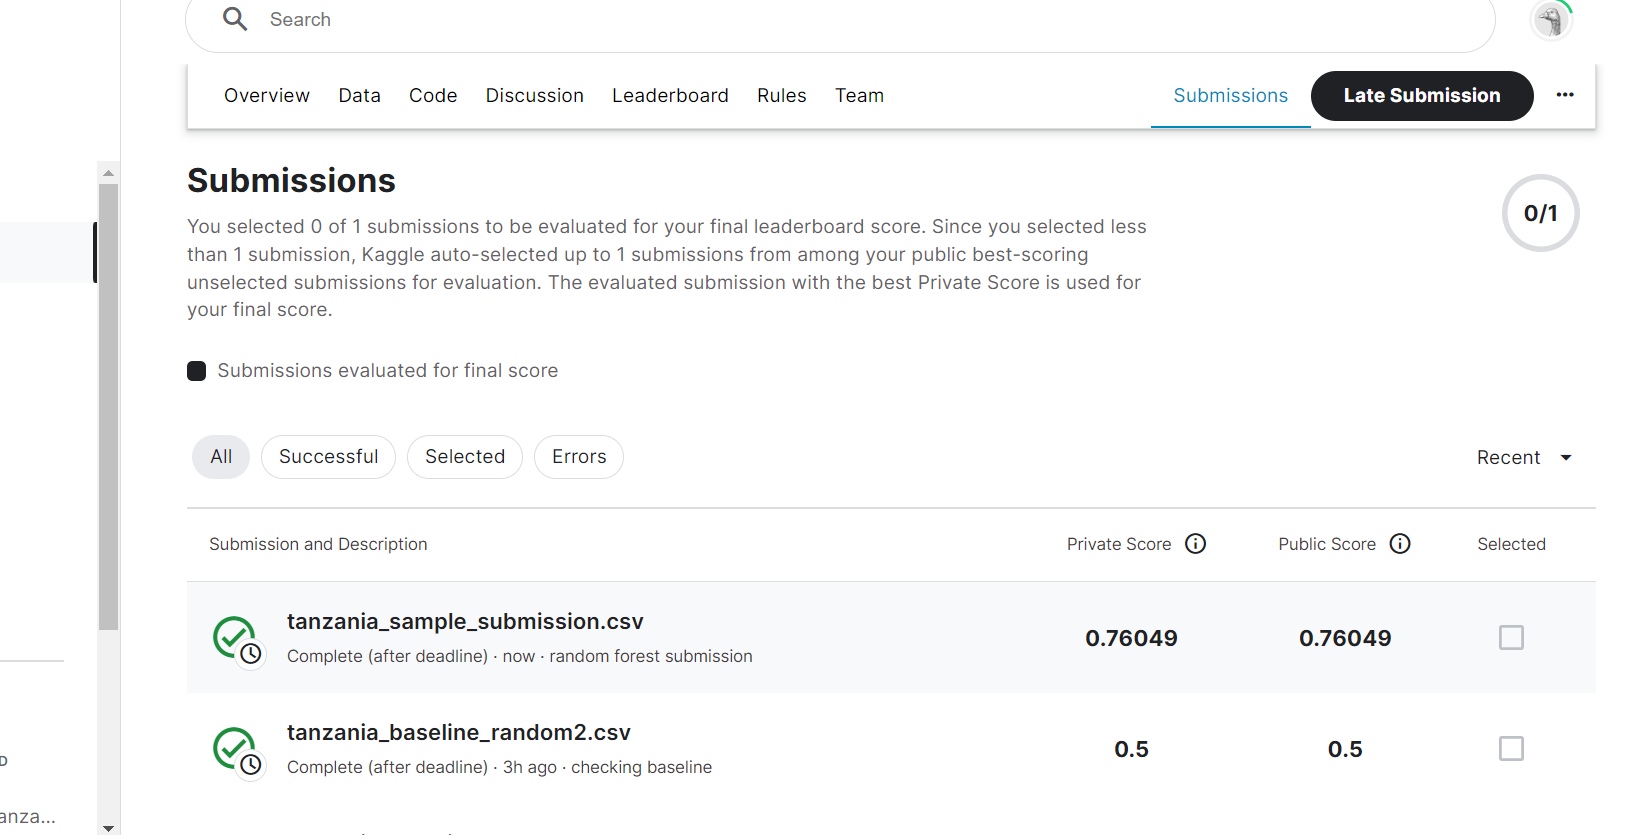